# Modeling the effects of artesunate on erythropoesis in malariainfection

erste Version ohne Immunsystem, Medikament, aber mit Erythropoese,Parasit

In [1]:
#packages
import pandas as pd
import seaborn as sns
import numpy as np
import tellurium as te
import matplotlib.pyplot as plt

## Data von Florian

In [2]:
# import data from florian
data_df = pd.read_csv('./PADH_sample_set.csv')
data_df = data_df[['Tag', 'OIE ‰', 'infected ‰', 'Hb (g/l)', 'Retis ‰']]

data_df.head()

,Tag,OIE ‰,infected ‰,Hb (g/l),Retis ‰
0,1.0,35.849057,391.644205,9.6,NaN
1,NaN,NaN,NaN,NaN,NaN
2,3.0,199.074074,87.268519,8.1,NaN
3,4.0,350.279330,0.000000,7.6,13.3
4,NaN,NaN,NaN,NaN,NaN


## Scheme
![model schmeme](schema_erythropoese_5.svg)


## Model

In [9]:
#Steady State

E_tot= 5e6
t_R_aging   = 1          
t_E_death   = 120 

#R0  = E_tot * (t_R_aging) / (t_E_death)  #für steady state
R0   = E_tot * 1/ 120 

#P0  = (R0 * (k_R_death +k_R_aging))/ (16* k_P_aging)   
P0  = (R0* (0.001 + (np.log(2) / (1/2))))/ (16* np.log(2) / (10/2))

print ( R0, P0, R0/E_tot)

#EPO flux
b   = 100
c   = 0.04
hemoglobin= 137.25001
EPO = 15
P   = 26060

d = -np.log(0.5)/P
a   = EPO * (1-np.exp(-d*P))*(1+np.exp((hemoglobin-b)*c))

J_EPO_prod = a/ (1+np.exp((hemoglobin-b)*c))
J_EPO_decay = EPO * (1-np.exp(-d*P))


print (a,d)
print (J_EPO_prod, J_EPO_decay)



41666.666666666664 26060.451758344905 0.008333333333333333
40.77822970381671 2.6598126652338653e-05
7.5 7.5


In [12]:
OIE_model = """
#species initiation
EPO = 15       #in mU/mL , (Thi,2010) erreicht nach (El Hassan 1997)max. 1000 mU/mL (miliunits)
P   = 26061    
R   = 41667    #für SS berechnet
E   = 5e6      #cells, bezieht sich auf gesamtvolumen 1 mikroliter
niE = 0        #
iE  = 0        #in cells/(kg body weight*10^11)
OIE = 0        #once-infected Erys
M   = 0        #Merozoiten, Bei Infektion: 2* 10^5 (Ma, 2019)
A   = 0        #Antikörper
I   = 0        #Immun cells, bei Infektion 10^-2

#Reactions 
##erythropoisis
EPOprod:       -> EPO   ; J_EPO_prod             
EPOdecay:  EPO ->       ; J_EPO_decay
Pbirth:        -> P     ; J_P_birth 
Pdeath:      P ->       ; J_P_death
Page:        P -> 16 R  ; J_P_aging     #geschätzt
Rdeath:      R ->       ; J_R_death 
Raging:      R -> E     ; J_R_aging        
Edeath:      E ->       ; J_E_death       
##parasite lifecircle
Ealter:      E -> niE   ; J_E_alter   
niEdeath:  niE ->       ; J_niE_death  
infect:    E+M -> iE    ; J_E_infect     
iEdeath:    iE ->       ; J_iE_death     
iErupture:  iE -> 16 M  ; J_iE_rupture
Mdeath:      M ->       ; J_M_death
##Artesunate treatment
iE_ART:     iE -> diE   ; J_iE_ART     
diE_pitt:  diE -> oiE   ; J_diE_pitt 
diE_death: diE ->       ; J_diE_death 
oiEdeath:  oiE ->       ; J_oiE_death

#parameter initiation
#Lebenszeiten t
##Erythropoese
t_P_aging   = 10         #in days, Entwicklung von Stammzelle zum Retikulozyt dauert ca. 5-9 Tage, plus 3 Tage die er schon retikulozyte ist aber noch in Rückenmark
t_R_aging   = 1          #in days, Entwicklung R -> E dauert ca 4 Tage (3 tage knochenmark, 1 Tage im peripheren Blut)-> wir betrachten nur Retis in peripheren Blut
t_E_death   = 120        #in 1/days, 120 Tage E Lebensdauer s. Jorins Quellen
##Infection with parasite
t_niE_death = 20         #in days, geraten
t_iE_rupture= 4          #in days, dauert ca 4 Tage bis Ruptur, sinuskurvig (2010 Th)
##Artesunate treatment
t_diE_pitt  = 0.25       #in days, bei Medikamentengabe nach 8h Maximum an gepitteten RBCs
t_oiE_death = 10         #in days, Lebenspanne von 7-14 Tage(Fanello,2017), 7-21 (Arguin 2014) -> dort Verweise nachgehen

#random Zahlen
KI_P_death = 15          #EPO Wert bei gesunden Menschen


#Assignments
##Erythropoese
J_EPO_prod  := k_EPO_prod         # hier später Abhängigkeit von, oiE, diE, iE einfügen (Ma, 2019) vlt (Hassan 2009)
J_EPO_decay := EPO* k_EPO_decay
J_P_birth    = k_P_birth             
J_P_death   := P * k_P_death
J_P_aging   := P * k_P_aging
J_R_death   := R * k_R_death
J_R_aging   := R * k_R_aging
J_E_death   := E * k_E_death
##Infection with parasite
J_E_alter   := E  * k_E_alter
J_niE_death := niE* k_niE_death
J_E_infect  := M  * k_E_infect       # einbezug parasit?, E ersmal als Abhängigkeit ausgelassen da am Anfang E >> M -> mit Jorin absprechen+
J_iE_death  := iE * k_iE_death       #einbezug antibodies, spleen
J_iE_rupture:= iE * k_iE_rupture     #16-32M s.Cowman 2016, Anderson 1989, Diebner 2000
J_M_death   := M  * k_M_death
##Artesunate treatment
J_iE_ART    := iE  * k_iE_ART       #einbezug artesunat
J_diE_pitt  := diE * k_diE_pitt     # spleen
J_diE_death := diE * k_diE_death
J_oiE_death := oiE * k_oiE_death

#Raten
##Erythropoese
k_EPO_prod := 40.77822328/(1+exp((Hb-100)*0.04) )    # in #cell/day
k_EPO_decay:= 1-exp(-P* 2.659710604e-5)              # in 1/days, (Ma, 2009)
k_P_birth   = P * (k_P_death + k_P_aging)       # für SS umgestellt
k_P_death  := 1/(1+ (EPO/KI_P_death))     #geraten, muss hoch sein, da wenn EPO da ist, dese so stark erringert wird dass Erythropoese verstrkt wird 
k_P_aging   = ln(2) / (t_P_aging/2)       #in 1/days
k_R_death   = 0.001                       #in 1/days,  geraten
k_R_aging   = ln(2) / (t_R_aging/2)       #in 1/days 
k_E_death   = ln(2) / (t_E_death/2)       #in 1/days
##infection with parasit 
k_E_alter   = 0                           #bei Infektion: 0.15aus komischen paper 2022
k_niE_death = ln(2) / (t_niE_death/2)     #in 1/days
k_E_infect  = 0                           #bei Infektion:2.0* 10^-9 keine Einheit, Ma 2019
k_iE_death  = 0.025                       #in 1/days, Ma 2019
k_iE_rupture= ln(2) / (t_iE_rupture/2)    #in 1/days
k_M_death   = 48                          #in 1/days 2010 Thi 
##Artesunate treatment
k_iE_ART    = 0.01                        # geschätzt ohne Medikament, , ART hat 1h Halbwertszeit (Tilley 2016)
k_diE_pitt  = ln(2) / (t_diE_pitt  /2)    # bei Medikamentengabe nach 8h Maximum an gepitteten RBCs
k_diE_death = 0.001
k_oiE_death = ln(2) / (t_oiE_death/2)     #in 1/days               

              
#Hämoglobin           
#(noch diE, niE Volumen, iE, Konzentrationen hinzufügen)
##Volumen
R_Vol    = 100e-15        #in l, Jorin
E_Vol    = 80e-15         #=80 fL, in l, Jorin, =MCH
#niE_Vol =
iE_Vol   = 80e-15         #in l,   Jorin
#diE_Vol = 80e-15         #auf gleiches Volumen wie iE geschätzt
oiE_Vol  = 50e-15         #in l, Jorin
blood_Vol_total = 1e-6    # =1µl, in l, gesamtes Blutvolumen 
##Hb Konzentrationen
Hb_conc_R    = 300        #in g/l (Piva,2014) 
Hb_conc_E    = 340        #in g/l,  =MCHC, https://www.ucsfhealth.org/medical-tests/rbc-indices
#Hb_conc_niE =      
#Hb_conc_iE  = 
#Hb_conc_diE =
#Hb_conc_oiE = 
#Hämatokrit, Hämoglobin
Hkt     := (E_Vol * E + R_Vol * R) / blood_Vol_total                             #0.4 ~ 40 %, #hier fehlen noch MCHC von infected Zellen
Hb      := (E_Vol * E * Hb_conc_E + R_Vol * R * Hb_conc_R) / blood_Vol_total     #in g/l, hier fehlen noch MCHC von infected Zellen
Hb_g_dl := Hb/10


#Parasitemie
p := iE / (E + R + iE + oiE + niE + diE)    

      
"""

## Simulation

In [13]:
OIE = te.loada(OIE_model)
#OIE.exportToSBML('./OIE.xml')

137.25001
7.499998818520919 7.499999999613709


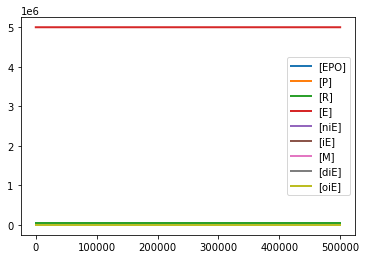

0.4041702486819974
0.008264462809917356


In [16]:
OIE = te.loada(OIE_model)
print(OIE.Hb)
print(OIE.J_EPO_prod, OIE.J_EPO_decay)

result = OIE.simulate (0, 500000)
OIE.plot(result)

print(OIE.Hkt)
print(OIE.R/(OIE.R+OIE.E))




In [ ]:
OIE = te.loada(OIE_model)
print(OIE.J_EPO_prod,OIE.J_EPO_decay)
result = OIE.simulate (0, 6000, ['time', '[E]'])
OIE.plot(result)

In [ ]:
OIE.selections

In [ ]:
OIE.getSimulationData()